# Fermi 4LAC DR3 x Fink

In [1]:
import pandas as pd
import numpy as np

from astropy.table import Table

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

## Crossmatch: description

This notebook describes the crossmatch between the Fourth LAT AGN Catalog DR3 (https://fermi.gsfc.nasa.gov/ssc/data/access/lat/4LACDR3/) and Fink ZTF alerts (https://fink-broker.org). 

The Fermi catalogs used has been downloaded and can be found under `data/fermi`. There are two catalogs:

In [2]:
dat = Table.read('../data/fermi/table-4LAC-DR3-h.fits', format='fits')
pdf_4lac_h = dat.to_pandas()

dat = Table.read('../data/fermi/table-4LAC-DR3-l.fits', format='fits')
pdf_4lac_l = dat.to_pandas()

pdf_4lac = pd.concat([pdf_4lac_h, pdf_4lac_l])

msg = """
4LAC DR3 high-latitude: {} sources
4LAC DR3 low-latitude :  {} sources
---
Total: {} sources
""".format(len(pdf_4lac_h), len(pdf_4lac_l), len(pdf_4lac))

print(msg)


4LAC DR3 high-latitude: 3407 sources
4LAC DR3 low-latitude :  407 sources
---
Total: 3814 sources



The Fink data used are all the alerts from 11/2019 to 10/2022. As of 04/10/2022, there are 102,374,541 alerts available (https://fink-portal.org/stats).

We took all sources from Fermi, and all alerts from Fink, and we performed the crossmatch. To start, we set the crossmatch radius to 1 arcmin. For all match, we concatenate into unique _objects_ (in Fink an object can emit several alerts), and we join the data from Fermi catalogs, plus some data from Fink:
- ZTF object ID (`objectId`), Fink classification (`finkclass`), the vector of times (`cjd`), the vector of passbands (`cfid`), the vector of magnitudes (`dcmag`), and the vector of magnitude error estimates (`dcmagerr`)

The result of the crossmatch, per catalog, can be found under `data/crossmatch`:

In [3]:
pdf_fink_4lac_h = pd.read_parquet('../data/crossmatch/table-4LAC-DR3-h_x_fink_1arcmin.parquet')
pdf_fink_4lac_l = pd.read_parquet('../data/crossmatch/table-4LAC-DR3-l_x_fink_1arcmin.parquet')

pdf_fink_4lac = pd.concat([pdf_fink_4lac_h, pdf_fink_4lac_l])

msg = """
Fink x 4LAC DR3 high-latitude: {} sources
Fink x 4LAC DR3 low-latitude :  {} sources
---
Total: {} sources
Fraction of Fermi sources: {:.1f}%
""".format(
    len(pdf_fink_4lac_h), 
    len(pdf_fink_4lac_l), 
    len(pdf_fink_4lac), 
    len(pdf_fink_4lac)/len(pdf_4lac)*100
)

print(msg)


Fink x 4LAC DR3 high-latitude: 582 sources
Fink x 4LAC DR3 low-latitude :  52 sources
---
Total: 634 sources
Fraction of Fermi sources: 16.6%



We have a total of 634 sources matching at 1 arcmin (about 17%).

## Classification of objects

Let's have a look at the classes of objects in Fink:

In [4]:
pdf_fink_4lac\
    .groupby('finkclass')\
    .count()\
    .sort_values('objectId', ascending=False)[['objectId']]

,objectId
finkclass,
BLLac,359
QSO,111
Unknown,68
Blazar,20
Radio,14
Seyfert_1,13
Blazar_Candidate,7
Candidate_EB*,7
MIR,5


Good, mostly BLLac & QSO. More interesting, there are some `Unknown` (i.e. no classification in Fink). We can also found likely false associations from the crossmatch, such as SN candidate, variable stars (EB*, V*, RRLyr, ...).

## ZTF lightcurves

In [5]:
# Number of object to display
N = 20

https://fink-portal.org/ZTF18abmnirp


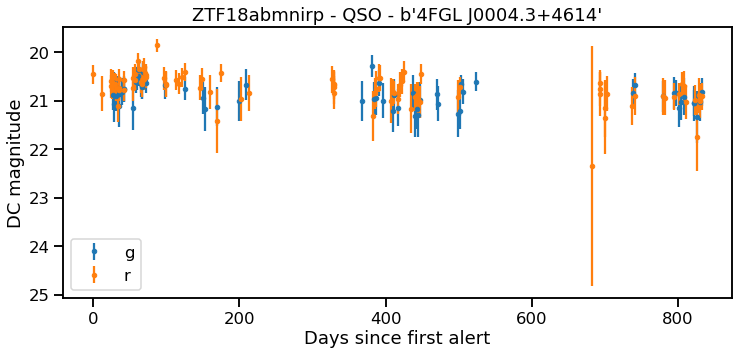

https://fink-portal.org/ZTF18abmjonj


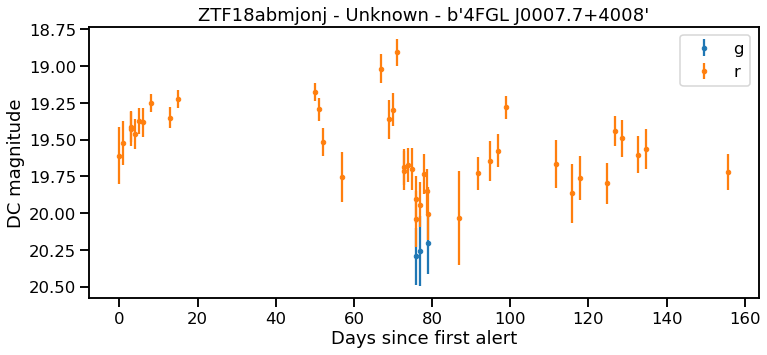

https://fink-portal.org/ZTF18achkcym


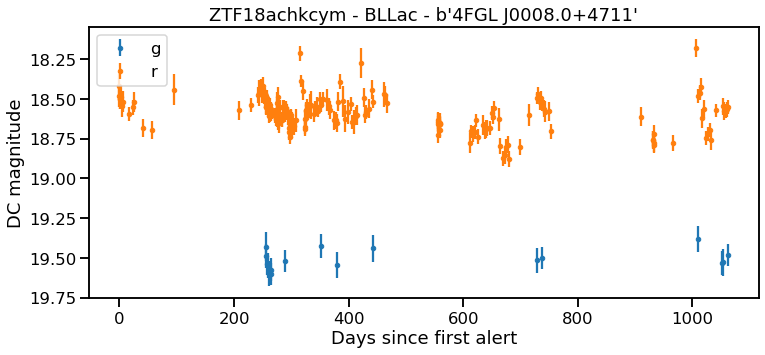

https://fink-portal.org/ZTF18abtworo


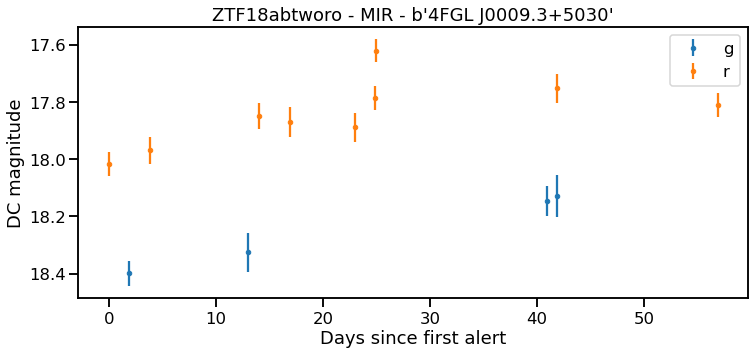

https://fink-portal.org/ZTF18abjhnbg


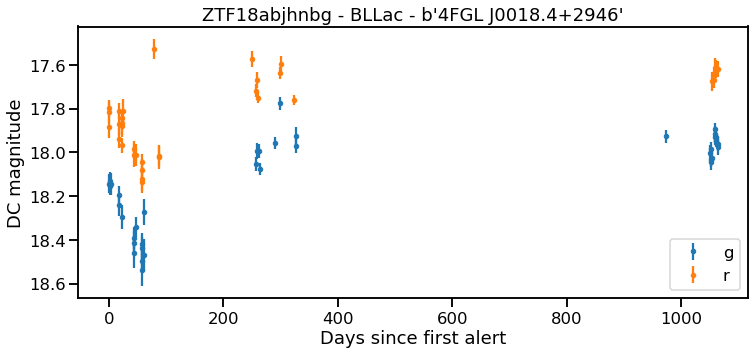

https://fink-portal.org/ZTF19abizmkp


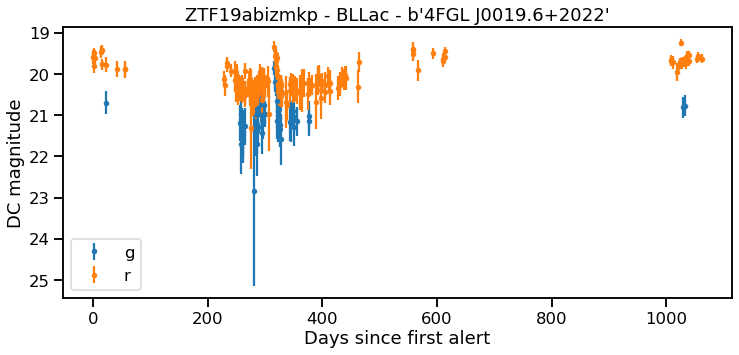

https://fink-portal.org/ZTF18acejbcb


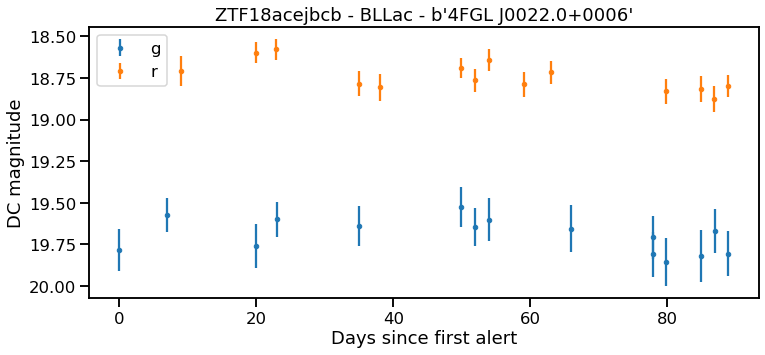

https://fink-portal.org/ZTF18abxeiyk


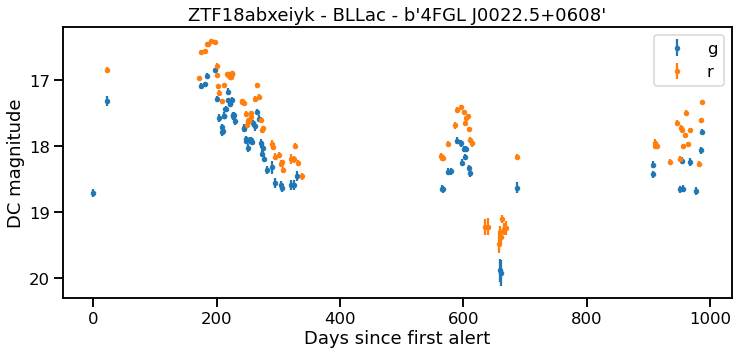

https://fink-portal.org/ZTF18abnckcm


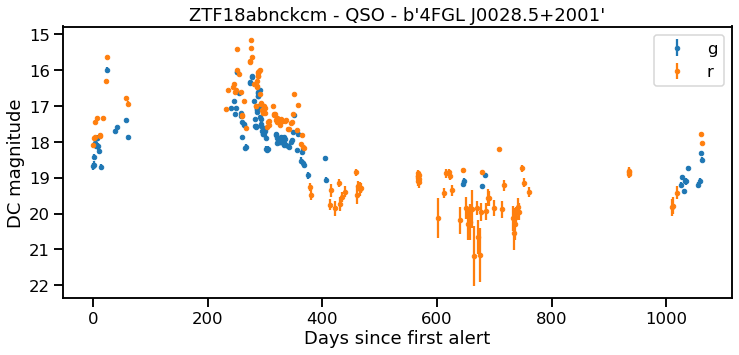

https://fink-portal.org/ZTF18abtftkf


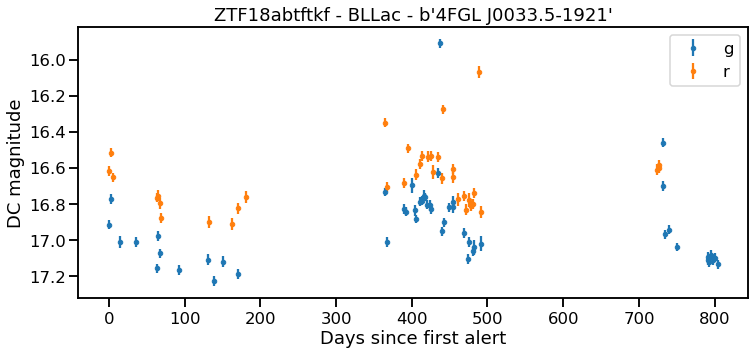

https://fink-portal.org/ZTF18abnyznq


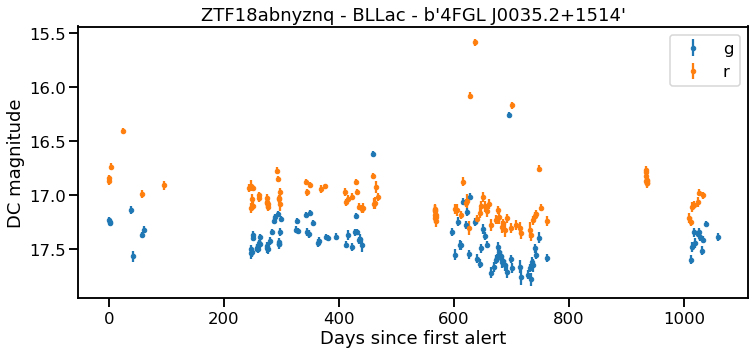

https://fink-portal.org/ZTF18abodqmb


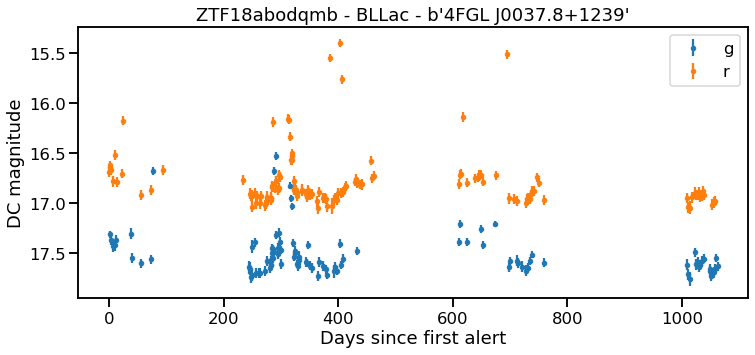

https://fink-portal.org/ZTF19aaabtts


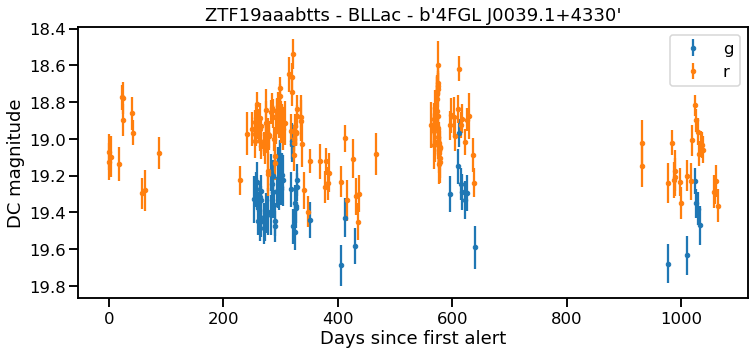

https://fink-portal.org/ZTF19achuafy


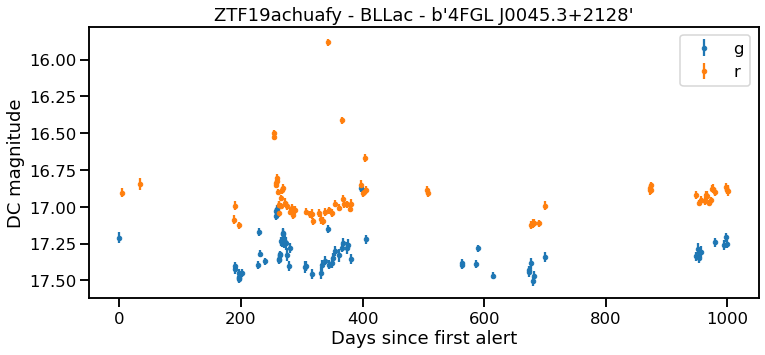

https://fink-portal.org/ZTF18abtleal


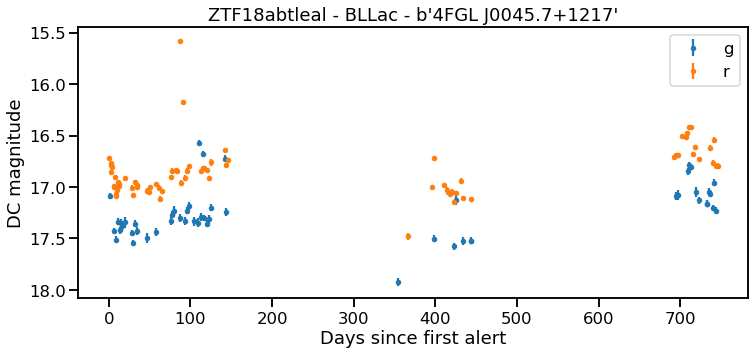

https://fink-portal.org/ZTF19abkhmxa


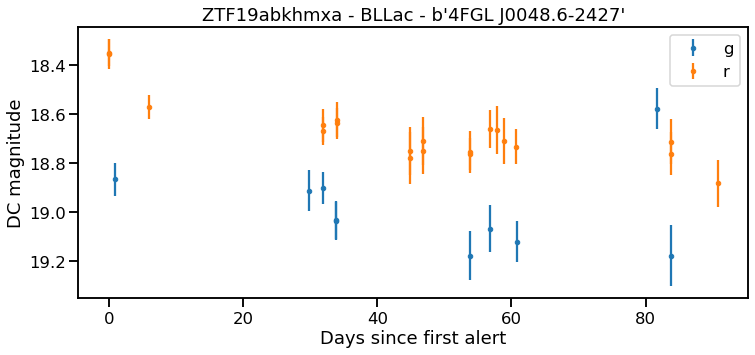

https://fink-portal.org/ZTF20acdbqyx


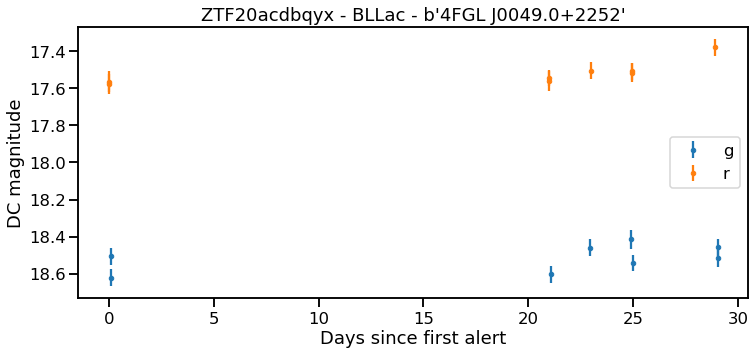

https://fink-portal.org/ZTF18abscgic


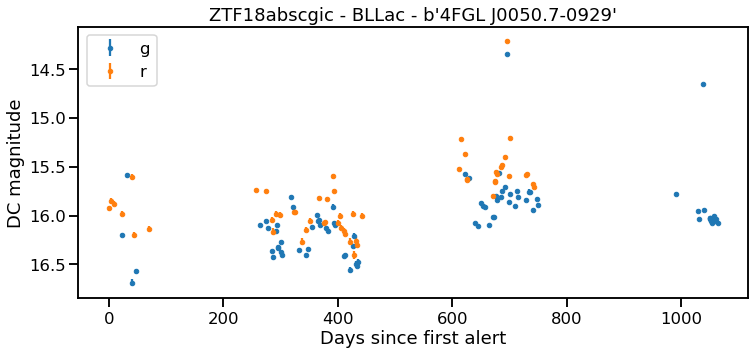

https://fink-portal.org/ZTF18abuvchc


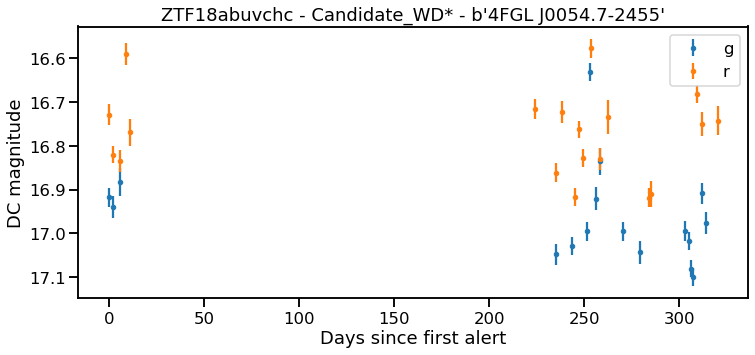

https://fink-portal.org/ZTF18abqursc


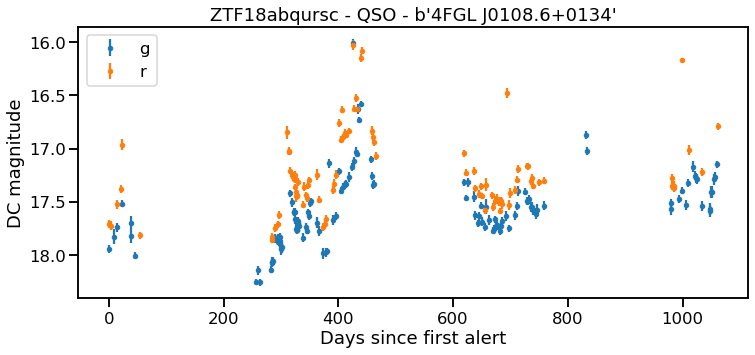

In [6]:
dicname = {1: 'g', 2: 'r'}
for index, row in enumerate(pdf_fink_4lac.iterrows()):
    if index >= N:
        break
    data = row[1]
    print('https://fink-portal.org/{}'.format(data['objectId']))
    
    fig = plt.figure(figsize=(12, 5))
    
    for filt in [1, 2]:
        mask = data['cfid'] == filt
        if np.sum(mask) == 0:
            continue
        plt.errorbar(
            data['cjd'][mask] - np.sort(data['cjd'])[0], 
            data['dcmag'][mask], 
            data['dcmagerr'][mask], 
            ls='', 
            marker='.', 
            label=dicname[filt],
            color='C{}'.format(filt - 1)
        )
    plt.legend()
    plt.ylabel('DC magnitude')
    plt.xlabel('Days since first alert')
    plt.title('{} - {} - {}'.format(data['objectId'], data['finkclass'], data['Source_Name']))
    
    plt.gca().invert_yaxis()
    plt.show()

## Sky location

Crappy script to look at the sky distribution...

In [7]:
from collections import Counter
import healpy as hp

def plot_mwd(RA,Dec,color,ax, cmap='viridis', alpha=0.5, cb=True,org=0,title=None, cb_title='magnitude',projection='mollweide'):
    ''' RA, Dec are arrays of the same length.
    RA takes values in [0,360), Dec in [-90,90],
    which represent angles in degrees.
    org is the origin of the plot, 0 or a multiple of 30 degrees in [0,360).
    title is the title of the figure.
    projection is the kind of projection: 'mollweide', 'aitoff', 'hammer', 'lambert'
    '''
    x = np.remainder(RA+360-org,360) # shift RA values
    ind = x>180
    x[ind] -= 360    # scale conversion to [-180, 180]
    x=-x    # reverse the scale: East to the left
    tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
    tick_labels = np.remainder(tick_labels+360+org,360)
    cm = ax.scatter(
        np.radians(x),
        np.radians(Dec), 
        c=color,
        alpha=alpha,
        marker='.',
        cmap=cmap
    )  # convert degrees to radians
    if cb:
        cb = fig.colorbar(cm)
        cb.set_label(cb_title)
        
    if title is not None:
        tick_labels = np.array(['', '120', '', '60', '', '0', '', '300', '', '240', ''])
        ax.set_xticklabels(tick_labels)     # we add the scale on the x axis
        ax.set_title(title)
        ax.title.set_fontsize(15)
        ax.set_xlabel("RA")
        ax.xaxis.label.set_fontsize(12)
        ax.set_ylabel("Dec")
        ax.yaxis.label.set_fontsize(12)
        ax.grid(True)

def dec2theta(dec: float) -> float:
    """ Convert Dec (deg) to theta (rad)
    """
    return np.pi / 2.0 - np.pi / 180.0 * dec

def ra2phi(ra: float) -> float:
    """ Convert RA (deg) to phi (rad)
    """
    return np.pi / 180.0 * ra

def get_ppix(pdf, nside=1024):

    pixs = hp.ang2pix(
        nside, 
        dec2theta(pdf['DEJ2000'].values),
        ra2phi(pdf['RAJ2000'].values),
        lonlat=True
    )
    
    pdict = Counter(pixs)

    ppixs = [pdict[i] for i in pixs]
    
    return ppixs

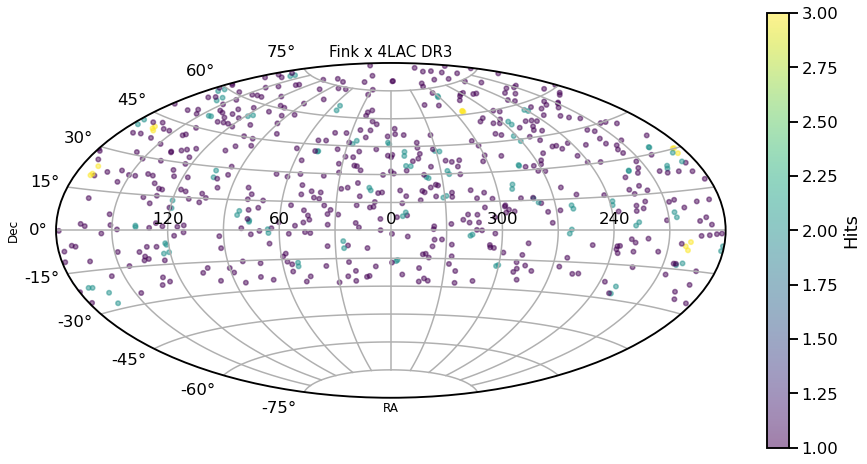

In [8]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, projection='aitoff')

ppixs = get_ppix(pdf_fink_4lac, 1024)
plot_mwd(
    pdf_fink_4lac['RAJ2000'].values, 
    pdf_fink_4lac['DEJ2000'].values, 
    ppixs, 
    ax=ax, 
    title='Fink x 4LAC DR3', 
    cb_title='Hits',
    alpha=0.5,
    org=0
)

## Next

1. Check time correlation
2. Play with bigger crossmatch radius
3. play with the multi-wavelength data :-)